In [43]:
import numpy as np
import torch
from comet_ml import Experiment,ExistingExperiment
from comet_ml.integration.pytorch import log_model
import yaml
import h5py
import matplotlib.pyplot as plt
from Finetune_hep.python import train,helpers,models

device = helpers.get_device()
print(device)

cpu


# **Models**

The networks consist of a reconstruction-level network (`backbone`) for jets that operates on constituents, to which output we can add high-level features (`HLF`). These representations of all jets within the event then enter a permutation-invariant analysis-level network (`head`).

<img src="figures/Architectures-color-title.png" alt="Alt text" width="500">

from `models.py` one can load 2(+2) types of models by passing a `config/config_file.yaml`:
1) backbone
 - `config/ParT_Xbb_config.yaml` will build the ParT Jet backbone with final linear layer projecting to a scalar value, to be (pre-)trained on the Xbb task
2) end-to-end models
- `config/ParT_<JetRepresentation>_config.yaml` will build the end-to-end model with a given intermediate representation of the ParT Jet backbone.
    - JetRepresentation = `latent`(V-only),`latent_hlf`(V+HLF),`Xbb_hlf`(S+HLF) 

In [44]:
data_config_Xbb = 'config/ParT_Xbb_config.yaml'
data_config_latent = 'config/ParT_latent_config.yaml'
data_config_latent_hlf = 'config/ParT_latent_hlf_config.yaml'
data_config_Xbb_hlf = 'config/ParT_Xbb_hlf_config.yaml'

# **Dataset**

the dataset can be found here https://cernbox.cern.ch/s/EDo8Z9FY1ZOewZT
- it's essentially a reshape of this jet-wise dataset http://opendata.cern.ch/record/12102

the first step is to zero-pad the empy pf features and missing jets: the script `run_H5_full.py` does the job by selecting events with 2>=njets<=5 and zero padding saving to `.h5`

note: having the zero padding as preprocessing makes the whole dataset ~3.5T and batch sampling quite slow => todo: revisit this or zeropad after sampling

In [76]:
#signal sample with Xm=600
!python python/H5_full.py --fname data/root/Sig_4.root --mass 600 --mess {str(4)} --out data/h5/ --testonly

<TTree 'tree' (152 branches) at 0x00013206fc50>
0.6421319796954315
batch number 1 out of 1
759 events
2
2
(15, 608, 2, 100)
3
3
(15, 136, 3, 100)
4
4
(15, 12, 4, 100)
5
5
(15, 3, 5, 100)
1.0


In [101]:
#bkg sample (Xm=0)
!python python/H5_full.py --fname data/root/Bkg_344.root --mass 0 --mess {str(344)} --out data/h5/ --testonly --bkg

<TTree 'tree' (152 branches) at 0x00014fca9890>
1.0
batch number 1 out of 1
2394 events
2
2
(15, 1873, 2, 100)
3
3
(15, 451, 3, 100)
4
4
(15, 63, 4, 100)
5
5
(15, 7, 5, 100)
1.0


the output `.h5` file will look like this (train/val/test split is 80/10/10)

In [46]:
with h5py.File('data/h5/Data_test_600.0_4.h5', 'r') as sample_sig:
    print(sample_sig.keys())
    print(sample_sig['X_jet'].shape)
    print(helpers.jVars)
    print(sample_sig['X_pfo'].shape)
    print(helpers.pVars)
    print(sample_sig['X_label'].shape)
    print(helpers.labelVars)        

<KeysViewHDF5 ['X_jet', 'X_jet_singlejet', 'X_label', 'X_label_singlejet', 'X_pfo', 'X_pfo_singlejet', 'jet_mask', 'labels', 'mass_param']>
(607, 5, 6)
['fj_pt', 'fj_eta', 'fj_doubleb', 'fj_phi', 'fj_mass', 'fj_sdmass']
(607, 5, 100, 15)
['pfcand_ptrel', 'pfcand_erel', 'pfcand_etarel', 'pfcand_phirel', 'pfcand_dxy', 'pfcand_dxysig', 'pfcand_dz', 'pfcand_dzsig', 'pfcand_deltaR', 'pfcand_charge', 'pfcand_isChargedHad', 'pfcand_isNeutralHad', 'pfcand_isGamma', 'pfcand_isEl', 'pfcand_isMu']
(607, 5, 6)
['label_QCD_b', 'label_QCD_bb', 'label_QCD_c', 'label_QCD_cc', 'label_QCD_others', 'label_H_bb']


Finally, to build the inputs for ParT, defined in the paper, we can use `build_features_and_labels_Xbb` (if we are preparing inputs for the Xbb jet backbone) or `build_features_and_labels` (if we want to pass the inputs to the end-to-end model) - more later

In [47]:
with h5py.File('data/h5/Data_test_600.0_4.h5', 'r') as sample_sig:
    data_Xbb = {}
    data_Xbb['X_jet'] = sample_sig['X_jet_singlejet'][:]
    data_Xbb['X_pfo'] = sample_sig['X_pfo_singlejet'][:]
    data_Xbb['labels'] = sample_sig['X_label_singlejet'][:]
    inputs_Xbb = helpers.build_features_and_labels_Xbb(data_Xbb)
print(inputs_Xbb.keys())    

dict_keys(['pf_points', 'pf_features', 'pf_vectors', 'pf_mask', 'label'])


in the training script (`training.py`) the inputs are prepared automatically based on the config file

# **Backbone Xbb pre-training**

first build the model by passing the config file with 
- `for_inference=False`: this removes the sigmoid (included in the loss for better numerical stability)
- `save_representaions=False`: setting this to true skips the linear layer projecting the 128 vector representation to 1 scalar in the forward pass - useful at inference step if the event head is then trained on this frozen representation

In [48]:
model_Xbb = models.full_model(data_config_Xbb,for_inference=False,save_representaions=False)  

`model.Task` shows the training target (will also be picked up by the training script)

In [49]:
model_Xbb.Task

'Xbb'

to train the model one needs to run the `training.py` script (see `config/slurm` examples) - remember to put your comet `api_key` and `ws`
- let's assume here the model is already trained and just get the scores on the test set. This is normally done with the `save_scores.py` script

- load the weights (note `for_inference=True`) - the loading function will copy only the weight w/ the same name between the two models, so it can also be used to load the backbone weights in the end-to-end models

In [78]:
model_Xbb = models.full_model(data_config_Xbb,for_inference=True,save_representaions=False)  
model_Xbb = helpers.load_weights(model_Xbb,'models/Xbb_task_lr0.001_bs512_subset1.0.pt',device)

loading weights :
dict_keys(['Xbb.0.weight', 'Xbb.0.bias', 'mod.cls_token', 'mod.embed.input_bn.weight', 'mod.embed.input_bn.bias', 'mod.embed.input_bn.running_mean', 'mod.embed.input_bn.running_var', 'mod.embed.input_bn.num_batches_tracked', 'mod.embed.embed.0.weight', 'mod.embed.embed.0.bias', 'mod.embed.embed.1.weight', 'mod.embed.embed.1.bias', 'mod.embed.embed.3.weight', 'mod.embed.embed.3.bias', 'mod.embed.embed.4.weight', 'mod.embed.embed.4.bias', 'mod.embed.embed.6.weight', 'mod.embed.embed.6.bias', 'mod.embed.embed.7.weight', 'mod.embed.embed.7.bias', 'mod.pair_embed.embed.0.weight', 'mod.pair_embed.embed.0.bias', 'mod.pair_embed.embed.0.running_mean', 'mod.pair_embed.embed.0.running_var', 'mod.pair_embed.embed.0.num_batches_tracked', 'mod.pair_embed.embed.1.weight', 'mod.pair_embed.embed.1.bias', 'mod.pair_embed.embed.2.weight', 'mod.pair_embed.embed.2.bias', 'mod.pair_embed.embed.2.running_mean', 'mod.pair_embed.embed.2.running_var', 'mod.pair_embed.embed.2.num_batches_track

- prepare the inputs 

In [79]:
with h5py.File('data/h5/Data_test_600.0_4.h5', 'r') as sample_sig:
    data_Xbb = {}
    data_Xbb['X_jet'] = sample_sig['X_jet_singlejet'][:]
    data_Xbb['X_pfo'] = sample_sig['X_pfo_singlejet'][:]
    data_Xbb['labels'] = sample_sig['X_label_singlejet'][:]
    inputs_Xbb = helpers.build_features_and_labels_Xbb(data_Xbb)
print(inputs_Xbb.keys())    
pf_points = torch.tensor(inputs_Xbb['pf_points']).float().to(device)
pf_features = torch.tensor(inputs_Xbb['pf_features']).float().to(device)
pf_vectors = torch.tensor(inputs_Xbb['pf_vectors']).float().to(device)
pf_mask = torch.tensor(inputs_Xbb['pf_mask']).float().to(device)    

dict_keys(['pf_points', 'pf_features', 'pf_vectors', 'pf_mask', 'label'])


/Users/matthiasvigl/Documents/Physics/EndToEnd/public/Finetune_hep/python/helpers.py:72: RuntimeWarning: divide by zero encountered in log
  result = np.log(ma_data)


- evaluate the tagger

In [80]:
with torch.no_grad():
    model_Xbb.eval()
    preds_Xbb = model_Xbb(pf_points,pf_features,pf_vectors,pf_mask)

/Users/matthiasvigl/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [81]:
preds_Xbb.shape

torch.Size([173, 1])

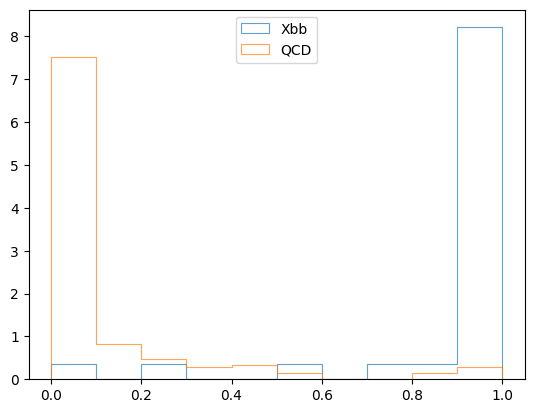

In [82]:
b=np.linspace(0,1,11)
fig, ax = plt.subplots()
ax.hist(preds_Xbb.detach().numpy(),weights=1*inputs_Xbb['label'], lw=0.8,bins=b,histtype='step', density=True, alpha=0.7, label='Xbb')
ax.hist(preds_Xbb.detach().numpy(),weights=1*(inputs_Xbb['label']==0), lw=0.8,bins=b,histtype='step', density=True, alpha=0.7, label='QCD')
ax.legend()

# **Event task training**

here there are 3 options based on the intermediate representation (V-only),(V+HLF) and (S+HLF):

In [83]:
model_latent = models.full_model(data_config_latent,for_inference=False,save_representaions=False)   #V-only
model_latent_hlf = models.full_model(data_config_latent_hlf,for_inference=False,save_representaions=False)  #V+HLF
model_Xbb_hlf = models.full_model(data_config_Xbb_hlf,for_inference=False,save_representaions=False) #S+HLF

let's go with the S+HLF 

In [84]:
model_Xbb_hlf.Task

'Event'

again, training is done with the `training.py` script (see `config/slurm` examples) - remember to put your comet `api_key` and `ws`

now let's assume we have a trained network

- load the weights (note for_inference=True)

In [91]:
model_Xbb_hlf = models.full_model(data_config_Xbb_hlf,for_inference=True,save_representaions=False) 
model_Xbb_hlf = helpers.load_weights(model_Xbb_hlf,'models/Finetune_Xbb_hl_lr0.001_bs256_subset1.0.pt',device)

loading weights :
dict_keys(['Xbb.0.weight', 'Xbb.0.bias', 'head.phi.0.weight', 'head.phi.0.bias', 'head.phi.2.weight', 'head.phi.2.bias', 'head.phi.4.weight', 'head.phi.4.bias', 'head.rho.0.weight', 'head.rho.0.bias', 'head.rho.2.weight', 'head.rho.2.bias', 'head.rho.4.weight', 'head.rho.4.bias', 'head.rho.6.weight', 'head.rho.6.bias', 'mod.cls_token', 'mod.embed.input_bn.weight', 'mod.embed.input_bn.bias', 'mod.embed.input_bn.running_mean', 'mod.embed.input_bn.running_var', 'mod.embed.input_bn.num_batches_tracked', 'mod.embed.embed.0.weight', 'mod.embed.embed.0.bias', 'mod.embed.embed.1.weight', 'mod.embed.embed.1.bias', 'mod.embed.embed.3.weight', 'mod.embed.embed.3.bias', 'mod.embed.embed.4.weight', 'mod.embed.embed.4.bias', 'mod.embed.embed.6.weight', 'mod.embed.embed.6.bias', 'mod.embed.embed.7.weight', 'mod.embed.embed.7.bias', 'mod.pair_embed.embed.0.weight', 'mod.pair_embed.embed.0.bias', 'mod.pair_embed.embed.0.running_mean', 'mod.pair_embed.embed.0.running_var', 'mod.pair_em

- prepare the inputs 

In [102]:
with h5py.File('data/h5/Data_test_600.0_4.h5', 'r') as sample_sig:
    data = {}
    data['X_jet'] = sample_sig['X_jet'][:]
    data['X_pfo'] = sample_sig['X_pfo'][:]
    data['labels'] = sample_sig['labels'][:]
    data['jet_mask'] = sample_sig['jet_mask'][:]
with h5py.File('data/h5/Data_test_0.0_344.h5', 'r') as sample_bkg:
    data['X_jet'] = np.concatenate((data['X_jet'],sample_bkg['X_jet'][:]),axis=0)
    data['X_pfo'] = np.concatenate((data['X_pfo'],sample_bkg['X_pfo'][:]),axis=0)
    data['labels'] = np.concatenate((data['labels'],sample_bkg['labels'][:]),axis=0)
    data['jet_mask'] = np.concatenate((data['jet_mask'],sample_bkg['jet_mask'][:]),axis=0)
    inputs = helpers.build_features_and_labels(data)  
print(inputs.keys())        

pf_points_event = torch.tensor(inputs['pf_points']).float().to(device)
pf_features_event = torch.tensor(inputs['pf_features']).float().to(device)
pf_vectors_event = torch.tensor(inputs['pf_vectors']).float().to(device)
pf_mask_event = torch.tensor(inputs['pf_mask']).float().to(device)
hl_feats = torch.tensor(inputs['hl_feats']).float().to(device)
jet_mask = torch.tensor(inputs['jet_mask']).float().to(device)

dict_keys(['pf_points', 'pf_features', 'pf_vectors', 'pf_mask', 'jet_mask', 'label', 'hl_feats'])


/Users/matthiasvigl/Documents/Physics/EndToEnd/public/Finetune_hep/python/helpers.py:72: RuntimeWarning: divide by zero encountered in log
  result = np.log(ma_data)
/Users/matthiasvigl/Documents/Physics/EndToEnd/public/Finetune_hep/python/helpers.py:72: RuntimeWarning: invalid value encountered in log
  result = np.log(ma_data)


- run the classifier

In [103]:
with torch.no_grad():
    model_Xbb_hlf.eval()
    preds = model_Xbb_hlf(pf_points_event,pf_features_event,pf_vectors_event,pf_mask_event,jet_mask,hl_feats)

/Users/matthiasvigl/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [104]:
preds.shape

torch.Size([316, 1])

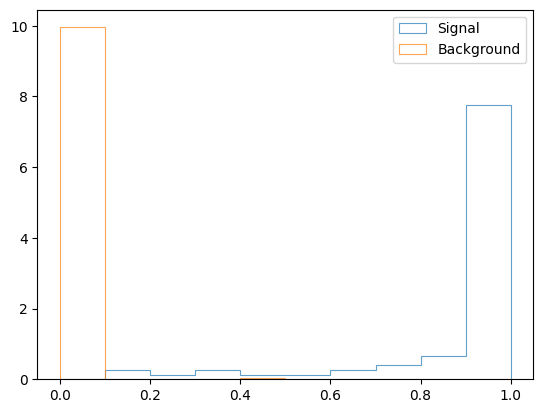

In [110]:
b=np.linspace(0,1,11)
fig, ax = plt.subplots()
ax.hist(preds.detach().numpy(),weights=1*inputs['label'], lw=0.8,bins=b,histtype='step', density=True, alpha=0.7, label='Signal')
ax.hist(preds.detach().numpy(),weights=1*(inputs['label']==0), lw=0.8,bins=b,histtype='step', density=True, alpha=0.7, label='Background')
ax.legend()

# About plotting

after saving the scores for different training strategies with `save_scores.py`, one can compare the performance on the event task with `plot.py` (see `config/slurm` examples)